In [167]:
!pip install torchinfo

In [168]:
%matplotlib inline
import matplotlib.image as mpimg
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from utils import read_all_images, img_crop
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Goodluck")

device = torch.device(device)

# Dataset loading

In [170]:
IMAGE_SRC_DIR = "training/images/"
IMAGE_GT_DIR = "training/groundtruth/"

IMAGES_SRC = torch.Tensor(np.asarray(read_all_images(IMAGE_SRC_DIR))).reshape((-1, 400, 400, 3))
IMAGES_GT = torch.Tensor(np.asarray(read_all_images(IMAGE_GT_DIR))).reshape((-1, 400, 400, 1))

print(IMAGES_SRC.size())
print(IMAGES_GT.size())

torch.Size([100, 400, 400, 3])
torch.Size([100, 400, 400, 1])


# Augment data

Testing multiple examples

In [171]:
"""
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomPosterize(bits=2),
    v2.RandomAdjustSharpness(sharpness_factor=2),
    #v2.RandAugment(),
    v2.ToDtype(torch.float32, scale=True)
])

N = 4

transformed = [
    transforms(IMAGES_SRC, IMAGES_GT)
    for _ in range(N)
]

augmented_src = torch.stack(
    [IMAGES_SRC] + [transformed[i][0] for i in range(N)]
).reshape(-1, 400, 400, 3)

augmented_gt = torch.stack(
    [IMAGES_GT] + [transformed[i][1] for i in range(N)]
).reshape(-1, 1, 400, 400)
augmented_gt = augmented_gt[:, 0, ...]

print(augmented_src.size())
print(augmented_gt.size())
"""
None

In [172]:
"""
policies = [v2.AutoAugmentPolicy.CIFAR10]
augmenters = [v2.AutoAugment(policy) for policy in policies]
augmenters += [v2.RandAugment()]

N = 4

imgs = [
    [augmenter(IMAGES_SRC, IMAGES_GT) for _ in range(N)]
    for augmenter in augmenters
]

augmented_src = torch.reshape(torch.Tensor([
  imgs[i][j][0]
  for i in range(augmenters)
  for j in range(N)
]), (-1, 3, ))

augmented_gt = torch.reshape(torch.Tensor([
  imgs[i][j][1]
  for i in range(augmenters)
  for j in range(N)
]), (-1, 3, ))

print(augmented_src.shape)
print(augmented_gt.shape)
"""
None

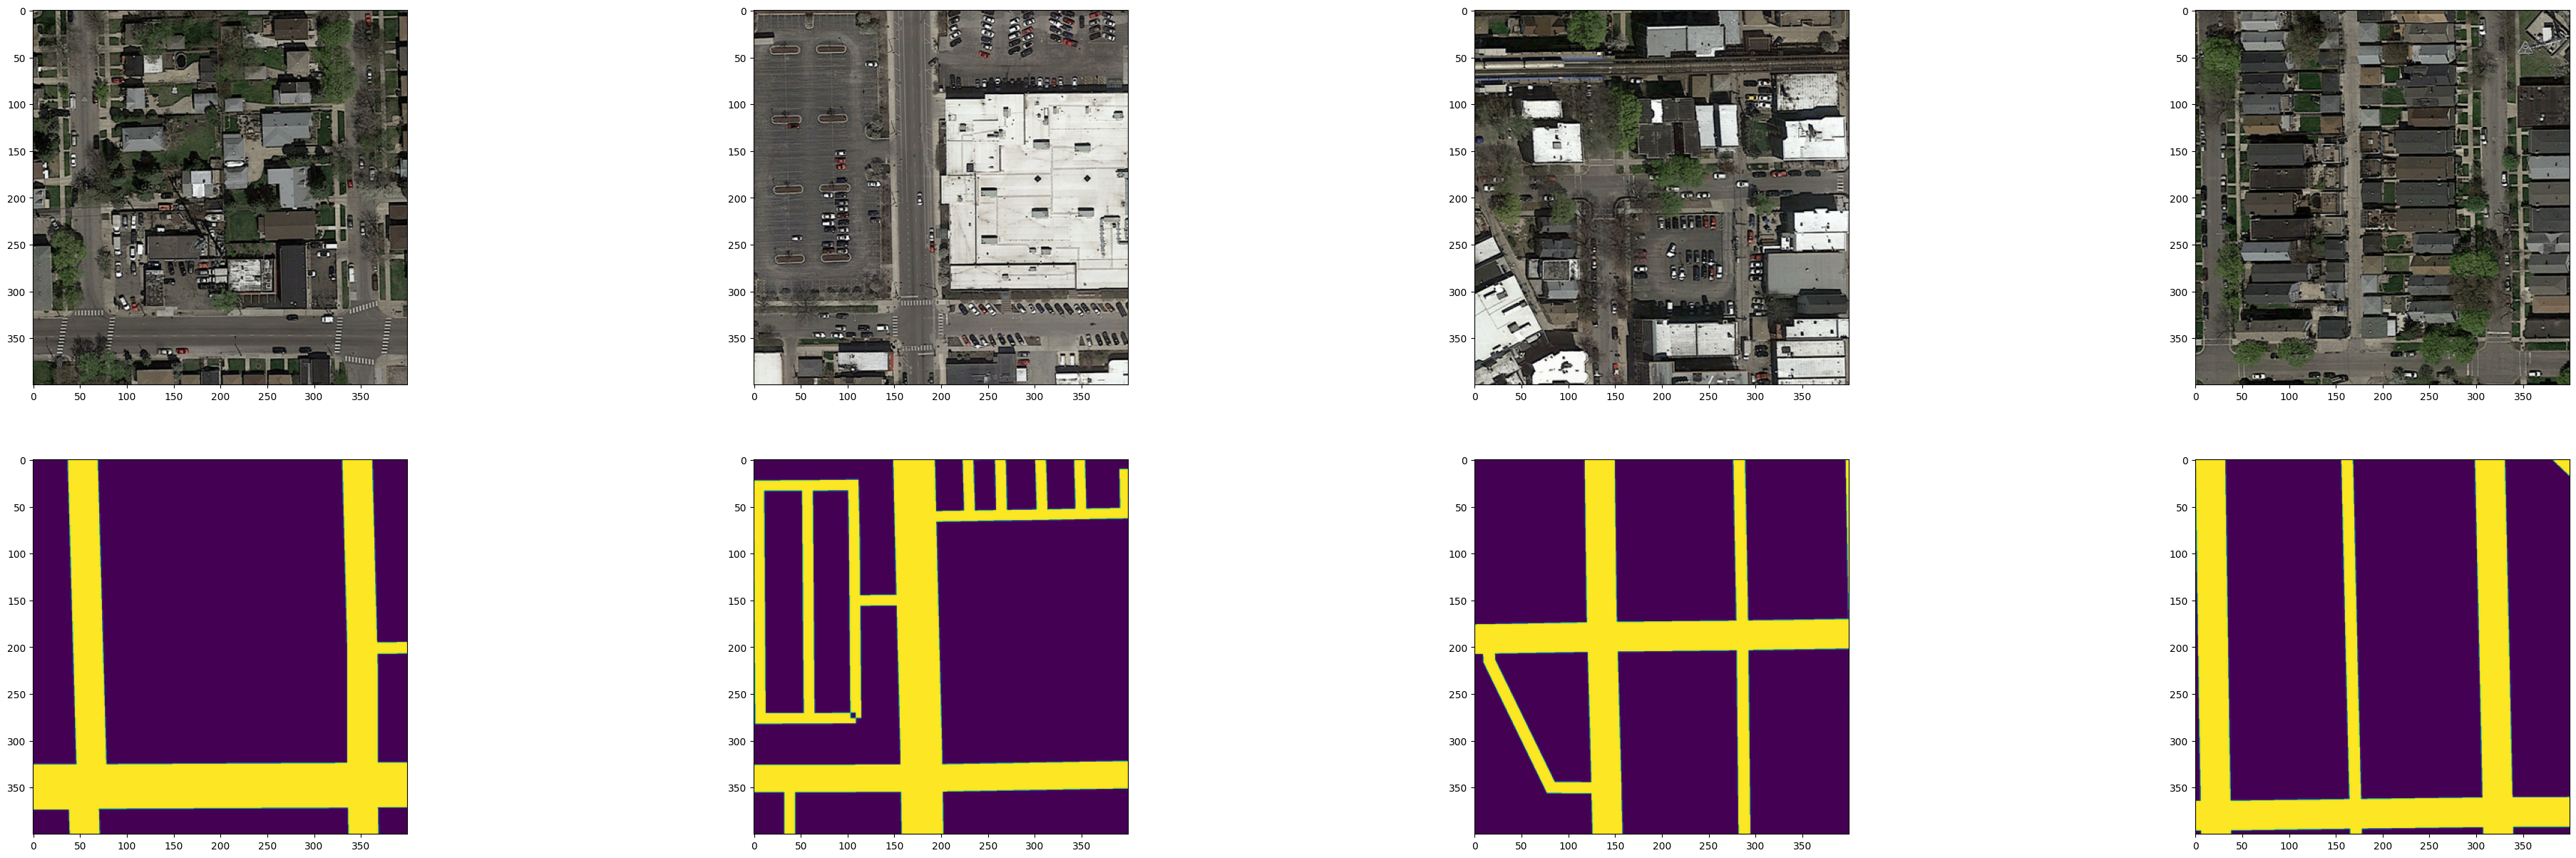

In [173]:
def visualize_data():
  fig = plt.figure(figsize=(50, 15))

  fig.add_subplot(2, 4, 1)
  plt.imshow(IMAGES_SRC[1])

  fig.add_subplot(2, 4, 2)
  plt.imshow(IMAGES_SRC[2])

  fig.add_subplot(2, 4, 3)
  plt.imshow(IMAGES_SRC[3])

  fig.add_subplot(2, 4, 4)
  plt.imshow(IMAGES_SRC[4])

  fig.add_subplot(2, 4, 5)
  plt.imshow(IMAGES_GT[1])

  fig.add_subplot(2, 4, 6)
  plt.imshow(IMAGES_GT[2])

  fig.add_subplot(2, 4, 7)
  plt.imshow(IMAGES_GT[3])

  fig.add_subplot(2, 4, 8)
  plt.imshow(IMAGES_GT[4])

  plt.show()

visualize_data()

## crop

In [187]:
PATCH_SIZE = 100
PATCH_SIZE_BIG = 200

range_ = torch.arange(400//PATCH_SIZE_BIG)
patch = torch.arange(PATCH_SIZE_BIG)
cropped_src = []
cropped_gt = []
for i, j in torch.cartesian_prod(range_, range_):
  rows = i*PATCH_SIZE_BIG + patch
  cols = j*PATCH_SIZE_BIG + patch

  patch_idx = torch.cartesian_prod(rows, cols).transpose(0, 1)
  cropped_src.append(IMAGES_SRC[:, patch_idx[0], patch_idx[1], :])
  cropped_gt.append(IMAGES_GT[:, patch_idx[0], patch_idx[1]])

cropped_src = torch.stack(cropped_src).reshape((-1, PATCH_SIZE_BIG, PATCH_SIZE_BIG, 3))
cropped_gt = torch.stack(cropped_gt).reshape((-1, PATCH_SIZE_BIG, PATCH_SIZE_BIG, 1))

print(cropped_src.shape)
print(cropped_gt.shape)

torch.Size([400, 200, 200, 3])
torch.Size([400, 200, 200, 1])


# Dataset loading

In [188]:
ds_src, ds_gt = cropped_src.transpose(1, 3), cropped_gt.transpose(1, 3)
#ds_src, ds_gt = IMAGES_SRC.transpose(1, 3), IMAGES_GT.transpose(1, 3) # ignore crop
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([400, 3, 200, 200])
torch.Size([400, 1, 200, 200])


In [189]:
#dataset = TensorDataset(ds_src, ds_gt)

import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

from torchvision.transforms import v2

import random

class CustomDataset(Dataset):
    def __init__(self, ds_src, ds_gt, train=True):
        self.images = ds_src
        self.targets = ds_gt

    def transform(self, image, target):
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(PATCH_SIZE, PATCH_SIZE))
        image = TF.crop(image, i, j, h, w)
        target = TF.crop(target, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            target = TF.hflip(target)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            target = TF.vflip(target)

        return image, target

    def __getitem__(self, index):
        image = self.images[index]
        target = self.targets[index]
        x, y = self.transform(image, target)
        return x, y

    def __len__(self):
        return len(self.images)

dataset = CustomDataset(ds_src, ds_gt)

## + splitting

In [190]:
def split_dataset(dataset):
  train_size = int(len(dataset) * 0.8)
  test_size = len(dataset) - train_size
  return torch.utils.data.random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(dataset)

# Model definition

In [178]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.mlp = nn.ModuleList([
            nn.Sequential(
              nn.Linear(20000, 20000),
              nn.LeakyReLU(0.1),
            )
            for i in range(0)
        ])

        self.unconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 3, stride=2, kernel_size=4, padding=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(start_dim=1)

        for layer in self.mlp:
          x = layer.forward(x)

        x = torch.reshape(x, (-1, 32, 25, 25))
        x = self.unconv(x)

        return x

summary(UNet(), input_size=(6, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [6, 3, 100, 100]          --
├─Sequential: 1-1                        [6, 32, 25, 25]           --
│    └─Conv2d: 2-1                       [6, 16, 100, 100]         1,216
│    └─BatchNorm2d: 2-2                  [6, 16, 100, 100]         32
│    └─MaxPool2d: 2-3                    [6, 16, 50, 50]           --
│    └─LeakyReLU: 2-4                    [6, 16, 50, 50]           --
│    └─Conv2d: 2-5                       [6, 32, 50, 50]           12,832
│    └─BatchNorm2d: 2-6                  [6, 32, 50, 50]           64
│    └─MaxPool2d: 2-7                    [6, 32, 25, 25]           --
│    └─LeakyReLU: 2-8                    [6, 32, 25, 25]           --
├─Sequential: 1-2                        [6, 3, 100, 100]          --
│    └─ConvTranspose2d: 2-9              [6, 16, 50, 50]           8,208
│    └─LeakyReLU: 2-10                   [6, 16, 50, 50]           --
│    

In [211]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()

        self.layers = nn.ModuleList([
            nn.Sequential(
              nn.Conv2d(12, 24, kernel_size=6, padding=2),
              nn.BatchNorm2d(24),
              nn.MaxPool2d(2),
              nn.LeakyReLU(0.1),
              nn.ConvTranspose2d(24, 12, stride=2, kernel_size=6, padding=1),
              nn.LeakyReLU(0.1)
            )
            for i in range(6)
        ])

    def forward(self, x):
        for layer in self.layers:
          x = layer(x)

        return x

summary(FCN(), input_size=(6, 12, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [6, 12, 100, 100]         --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [6, 12, 100, 100]         --
│    │    └─Conv2d: 3-1                  [6, 24, 99, 99]           10,392
│    │    └─BatchNorm2d: 3-2             [6, 24, 99, 99]           48
│    │    └─MaxPool2d: 3-3               [6, 24, 49, 49]           --
│    │    └─LeakyReLU: 3-4               [6, 24, 49, 49]           --
│    │    └─ConvTranspose2d: 3-5         [6, 12, 100, 100]         10,380
│    │    └─LeakyReLU: 3-6               [6, 12, 100, 100]         --
│    └─Sequential: 2-2                   [6, 12, 100, 100]         --
│    │    └─Conv2d: 3-7                  [6, 24, 99, 99]           10,392
│    │    └─BatchNorm2d: 3-8             [6, 24, 99, 99]           48
│    │    └─MaxPool2d: 3-9               [6, 24, 49, 49]           --
│  

In [223]:
class Model(nn.Module):
    def __init__(self, refinement_layers=3):
        super(Model, self).__init__()
        self.refinement_layers = refinement_layers

        self.up = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=8, padding="same"),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(0.1)
        )

        self.model = FCN()

        self.sumup = nn.Sequential(
            nn.ConvTranspose2d(12, 1, stride=2, kernel_size=4, padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.up(x)

        for i in range(self.refinement_layers):
            x = self.model.forward(x)

        x = self.sumup(x)

        return x.squeeze()

model = Model(refinement_layers=1)
#model.load_state_dict(torch.load("./checkpoint_240.pth"))
summary(model, input_size=(6, 3, 100, 100))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                        Output Shape              Param #
Model                                         [6, 100, 100]             --
├─Sequential: 1-1                             [6, 12, 100, 100]         --
│    └─Conv2d: 2-1                            [6, 12, 100, 100]         2,316
│    └─BatchNorm2d: 2-2                       [6, 12, 100, 100]         24
│    └─LeakyReLU: 2-3                         [6, 12, 100, 100]         --
├─FCN: 1-2                                    --                        --
│    └─ModuleList: 2-4                        --                        --
│    │    └─Sequential: 3-1                   [6, 12, 100, 100]         20,820
│    │    └─Sequential: 3-2                   [6, 12, 100, 100]         20,820
│    │    └─Sequential: 3-3                   [6, 12, 100, 100]         20,820
│    │    └─Sequential: 3-4                   [6, 12, 100, 100]         20,820
│    │    └─Sequential: 3-5                   [6, 12, 100, 100]         20,8

# Training!

In [215]:
from tqdm.notebook import tqdm
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).squeeze()
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append(((output > 0.5).eq(target > 0.5).sum() / target.numel()).item())

    return acc_history, loss_history

In [236]:
def train(device, batch_size=32, epochs=60):
    pytorchDl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00000001)
    criterion = torch.nn.functional.binary_cross_entropy

    for i in tqdm(range(epochs)):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        if i % 10 == 0:
          print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))
        if i%20==0:
          print("saving…")
          torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))

    return

# Let's play!

In [237]:
train(device, 256, 4000)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch:  0  Accuracy:  0.9537076056003571  Loss:  0.14169242978096008
saving…
Epoch:  10  Accuracy:  0.9567927420139313  Loss:  0.13611863553524017
Epoch:  20  Accuracy:  0.9505333602428436  Loss:  0.14981185644865036
saving…
Epoch:  30  Accuracy:  0.9525292813777924  Loss:  0.1453096941113472
Epoch:  40  Accuracy:  0.9523372650146484  Loss:  0.1456661969423294
saving…
Epoch:  50  Accuracy:  0.9548831880092621  Loss:  0.14134766161441803
Epoch:  60  Accuracy:  0.9556640386581421  Loss:  0.14180215448141098
saving…
Epoch:  70  Accuracy:  0.9470740258693695  Loss:  0.15623367577791214
Epoch:  80  Accuracy:  0.9513591527938843  Loss:  0.14349258691072464
saving…
Epoch:  90  Accuracy:  0.9538035094738007  Loss:  0.1432477906346321
Epoch:  100  Accuracy:  0.9511298537254333  Loss:  0.1482359692454338
saving…
Epoch:  110  Accuracy:  0.9527687430381775  Loss:  0.1456293910741806
Epoch:  120  Accuracy:  0.9541976153850555  Loss:  0.14157339930534363
saving…
Epoch:  130  Accuracy:  0.95500075817

KeyboardInterrupt: ignored

# Visualize results?

torch.Size([1, 3, 100, 100])
torch.Size([3, 100, 100])


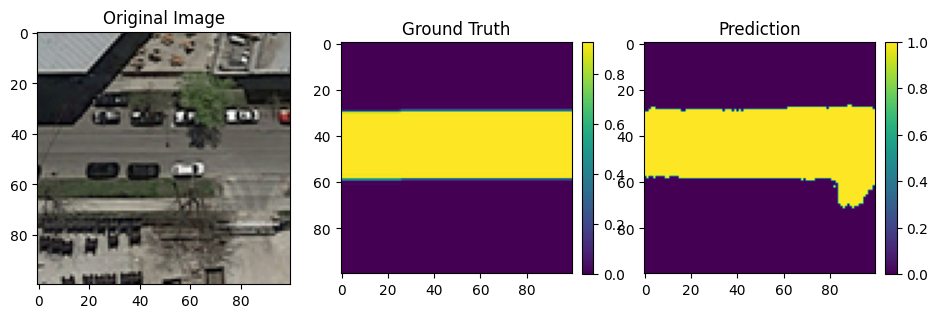

torch.Size([1, 3, 100, 100])
torch.Size([3, 100, 100])


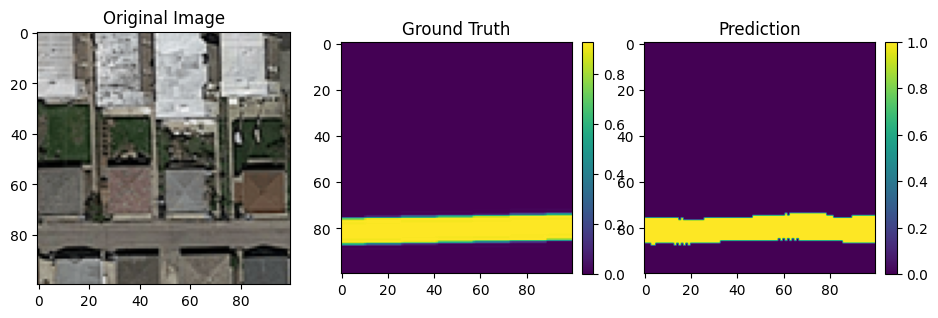

In [238]:
def visualize_result(device, model, dataset):
  model.eval()
  pytorchDl = DataLoader(dataset, batch_size=1, shuffle=True)
  for i, (data, target) in enumerate(pytorchDl):
    data = data.squeeze()
    target = target.squeeze()
    inputs = data.to(device).unsqueeze(0)
    print(inputs.size())
    print(data.size())
    output = model.forward(inputs).transpose(0, 1)
    data, target = data.transpose(0, 2), target.transpose(0, 1)

    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 4, 1)
    im = plt.imshow(data)
    plt.title("Original Image")
    fig.add_subplot(1, 4, 2)
    im = plt.imshow(target)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")
    fig.add_subplot(1, 4, 3)
    im = plt.imshow(output.cpu().detach().numpy() > 0.5)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prediction")
    plt.show()
    break

visualize_result(device, model, train_ds)
visualize_result(device, model, test_ds)

In [239]:
model.eval()
pytorchDl = DataLoader(train_ds, batch_size=32, shuffle=True)

model_ref = model.model
sumup_ref = model.sumup

acc_history_1 = []
acc_history_2 = []

refinements_1 = Model(refinement_layers=1)
refinements_1.sumup = sumup_ref
refinements_1.sumup = model_ref

refinements_2 = Model(refinement_layers=2)
refinements_2.sumup = sumup_ref
refinements_2.sumup = model_ref

for batch_idx, (data, target) in enumerate(pytorchDl):
    data, target = data, target

    output_1 = refinements_1.forward(data)
    output_2 = refinements_2.forward(data)

    acc_1 = ((output_1 > 0.5).eq(target > 0.5).sum() / target.numel()).item()
    acc_2 = ((output_2 > 0.5).eq(target > 0.5).sum() / target.numel()).item()

    acc_history_1.append(acc_1)
    acc_history_2.append(acc_2)

    print("Acc 1:", acc_1)
    print("Acc 2:", acc_2)

RuntimeError: ignored

# Making a submission

In [241]:
from mask_to_submission import masks_to_submission
from utils import img_float_to_uint8, load_image


TEST_SET_FOLDER = "test_set_images/"
SUBMISSION_NAME = "submission_antoine2.csv"
NUMBER_OF_TEST = 50

for i in range(1, NUMBER_OF_TEST+1):
  img = load_image(TEST_SET_FOLDER + "test_" + str(i) + "/" + "test_" + str(i) + ".png")
  img = transforms.ToTensor()(img).to(device)
  model.eval()
  output = model.to(device)(img.unsqueeze(0)).cpu().detach().numpy()
  output = img_float_to_uint8(output.squeeze())
  output_image = Image.fromarray(output)
  output_image.save("submission/" + str(i) + ".png")

masks_to_submission(SUBMISSION_NAME, *["submission/" + str(i) + ".png" for i in range(1, NUMBER_OF_TEST+1)])